# ***IMPORT***

In [712]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import plotly.express as px
import plotly.figure_factory as ff
%matplotlib inline 

from sklearn.preprocessing import StandardScaler,FunctionTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# ***READING DATA***

In [713]:
train=pd.read_csv("/content/train.csv", sep=";")
test=pd.read_csv("/content/test.csv", sep=";", usecols=range(13))

# ***FIRST LOOK AT THE DATA***

In [714]:
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19 kmpl,1396 CC,88.76 bhp,219.66nm@ 1500-2750rpm,5.0
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,12.55 kmpl,2982 CC,168.5 bhp,360Nm@ 1400-3200rpm,7.0
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01 kmpl,1591 CC,121.3 bhp,154.9Nm@ 4200rpm,5.0
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0


In [715]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        5841 non-null   object 
 9   engine         5841 non-null   object 
 10  max_power      5846 non-null   object 
 11  torque         5840 non-null   object 
 12  seats          5841 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 609.5+ KB


In [716]:
train.shape

(6000, 13)

In [717]:
train.ndim

2

# ***PRE-PROCESS***

In [718]:
def delete(x):
  if('kmpl' in str(x) or 'km/kg' in str(x) or 'kmlp' in str(x)):
    if('kmpl' in str(x)):
      return float(x.replace(' kmpl', ''))
    elif ('kmlp' in str(x)):
      return float(x.replace(' kmlp', ''))
    else:
      return float(x.replace(' km/kg', ''))*1.4
  elif('CC' in str(x)):
    return int(x.replace(' CC', ''))
  elif('bhp' in str(x)):
    if(len(x)>4):
      return float(x.replace(' bhp', ''))
    else:
      print(str(x))
      return np.nan
  elif("Nm" in str(x) or "rpm" in str(x) or "@" in str(x) or " / " in str(x) or "KGM" in str(x)):
    if("KGM" in str(x)):
      a = re.findall(r'\d+', x)
      if(len(a) == 1):
        return float(a[0])*2200*10
      elif(len(a) == 2):
        return float(a[0])*float(a[1])*10
      else:
        return float(a[0])*(float(a[1])/2+float(a[2])/2)*10
    else:
      a = re.findall(r'\d+', x)
      if(len(a) == 1):
        return float(a[0])*2200
      elif(len(a) == 2):
        return float(a[0])*float(a[1])
      else:
        return float(a[0])*(float(a[1])/2+float(a[2])/2)
  else:
    return float(x)

In [719]:
train['mileage'] = train['mileage'].apply(delete)
train['engine'] = train['engine'].apply(delete)
train['max_power'] = train['max_power'].apply(delete)
train['torque'] = train['torque'].apply(delete)

 bhp


In [720]:
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.50,1497.0,108.50,552500.0,5.0
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19,1396.0,88.76,171477.0,5.0
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,12.55,2982.0,168.50,828000.0,7.0
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01,1591.0,121.30,324093.0,5.0
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.00,1969.0,190.00,880000.0,5.0


In [721]:
train.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          159
engine           159
max_power        155
torque           160
seats            159
dtype: int64

In [722]:
train.dropna(inplace=True)
train.shape

(5840, 13)

In [723]:
numeric_col=[col for col in train if train[col].dtype !="object" ]
print(numeric_col)

['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']


In [724]:
categorical_col=[col for col in train if train[col].dtype=="object" ]
print(categorical_col)

['name', 'fuel', 'seller_type', 'transmission', 'owner']


In [725]:
def clean(x):
  a = str(x).split(" ")
  name = str(a[0]) + " " + str(a[1]) + " " +str(a[2])
  return name

train['name'] = train['name'].apply(clean)

# **EDA**

In [726]:
fig1 = px.scatter(train, x="selling_price", y="year")
fig1.show()
fig2 = px.scatter(train, x="selling_price", y="km_driven")
fig2.show()
fig3 = px.scatter(train, x="selling_price", y="fuel")
fig3.show()
fig4 = px.scatter(train, x="selling_price", y="seller_type")
fig4.show()
fig5 = px.scatter(train, x="selling_price", y="transmission")
fig5.show()
fig6 = px.scatter(train, x="selling_price", y="mileage")
fig6.show()
fig7 = px.scatter(train, x="selling_price", y="engine")
fig7.show()
fig8 = px.scatter(train, x="selling_price", y="max_power")
fig8.show()
fig9 = px.scatter(train, x="selling_price", y="torque")
fig9.show()
fig10 = px.scatter(train, x="selling_price", y="seats")
fig10.show()

In [727]:
fig = px.histogram(train, x="selling_price")
fig.show()

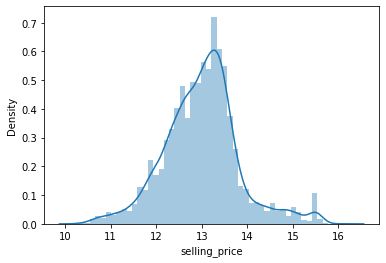

In [728]:
sns.distplot(np.log(train.selling_price))


In [729]:
Y = np.log(train.selling_price)

In [730]:
train.drop(["selling_price"], axis=1, inplace=True)
train.drop(["seller_type"], axis=1, inplace=True)
train.drop(["owner"], axis=1, inplace=True)

In [731]:
test.head()

,Id,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,1,Skoda Rapid 1.6 MPI AT Elegance,2016,11000,Petrol,Dealer,Automatic,First Owner,14.3 kmpl,1598 CC,103.5 bhp,153Nm@ 3800rpm,5
1,2,Honda City i VTEC V,2017,35000,Petrol,Individual,Manual,First Owner,17.8 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,5
2,3,Hyundai Xcent 1.2 Kappa SX Option,2014,80000,Petrol,Individual,Manual,First Owner,19.1 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5
3,4,Mahindra Scorpio 2009-2014 SLE 7S BSIII,2014,145241,Diesel,Individual,Manual,First Owner,12.05 kmpl,2179 CC,120 bhp,290Nm@ 1800-2800rpm,7
4,5,Ford Ecosport 1.5 Diesel Titanium,2015,92651,Diesel,Dealer,Manual,First Owner,21.7 kmpl,1498 CC,98.96 bhp,215Nm@ 1750-2500rpm,5


# ***MODELING***

In [732]:
test.dropna(inplace=True)
test.drop(["seller_type"], axis=1, inplace=True)
test.drop(["owner"], axis=1, inplace=True)

In [733]:
test['name'] = test['name'].apply(clean)

print("Before processing: ", test.shape)

Before processing:  (2128, 11)


In [734]:
test['mileage'] = test['mileage'].apply(delete)
test['engine'] = test['engine'].apply(delete)
test['max_power'] = test['max_power'].apply(delete)
test['torque'] = test['torque'].apply(delete)

In [735]:
test.dropna(inplace=True)
print("After processing: ", test.shape)

After processing:  (2128, 11)


In [736]:
test_id = test.Id
test.drop(["Id"], axis=1, inplace=True)

In [737]:
frames = [train,test]
result = pd.concat(frames)
print(result.shape)

X_test = result

(7968, 10)


In [738]:
cat_col=[col for col in X_test if X_test[col].dtype=="object" ]
X_test=pd.get_dummies(X_test,columns=cat_col,drop_first=True)

In [739]:
sc=StandardScaler()

X_test=sc.fit_transform(X_test)
X_test=pd.DataFrame(X_test)

print(X_test.shape)

(7968, 688)


In [740]:
X=X_test[:Y.shape[0]]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=42)

In [741]:
def evaluate(model):
  model.fit(x_train,y_train)

  y_pred_m=model.predict(x_test) 

  ft=FunctionTransformer(func=np.log1p,inverse_func=np.exp)
  inv_y_pred=ft.inverse_transform(y_pred_m)
  inv_y_test=ft.inverse_transform(y_test)

  print("Model name: ",model)
  print("R2 score  : ",r2_score(inv_y_test,inv_y_pred))
  print("MSE       : ",mean_squared_error(inv_y_test,inv_y_pred,squared=False))
  print("______________________________________________________________________")

In [742]:
lr=LassoCV()
rfr=RandomForestRegressor() 
R=RidgeCV()
knn=KNeighborsRegressor() 
svr=SVR() 
dtr=DecisionTreeRegressor() 

models=[lr,rfr,R,knn,svr,dtr]


In [748]:
for model in models:
    evaluate(model)

Model name:  LassoCV()
R2 score  :  0.9771211884709434
MSE       :  112362.81349002787
______________________________________________________________________
Model name:  RandomForestRegressor()
R2 score  :  0.9749092445925854
MSE       :  117669.1843818377
______________________________________________________________________
Model name:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
R2 score  :  0.9707267848252881
MSE       :  127098.69379622025
______________________________________________________________________
Model name:  KNeighborsRegressor()
R2 score  :  0.8754848039295932
MSE       :  262130.19655743137
______________________________________________________________________
Model name:  SVR()
R2 score  :  0.8960559038495294
MSE       :  239500.1492282839
______________________________________________________________________
Model name:  DecisionTreeRegressor()
R2 score  :  0.9690828663588178
MSE       :  130618.73889077298
_________________________________________________________

In [744]:
X_test = X_test[Y.shape[0]:]
X_test.shape

(2128, 688)

In [745]:
def test_model(model, mytest):
    y_pred_m=model.predict(mytest) 
    ft=FunctionTransformer(func=np.log1p,inverse_func=np.exp)
    inv_y_pred=ft.inverse_transform(y_pred_m)
    print("Model name: ",model)
    return inv_y_pred

y_test_x = test_model(rfr, X_test)

Model name:  RandomForestRegressor()


In [746]:
test_id = np.asarray(test_id, dtype=np.int32).reshape((-1,1))

y_test_x = np.asarray(y_test_x, dtype=np.int64).reshape((-1,1))
a = np.concatenate((test_id,y_test_x), axis=1)

# ***EXPORT***

In [747]:
prediction = pd.DataFrame(a, columns=["Id", "Predicted"])
prediction.to_csv("prediction.csv", index=False)